In [124]:
# train.csv 데이터로 생존자 분석 예측을 위한 분석용 데이터셋을 하나의 전처리 사용자 함수를 이용하여 작성한 후 모델링 및 성능 평가를 수행. 단,전처리는 5개 이상, 시각적 탐색 3가지 이상, 정확도는 0.85 이상
import pandas as pd
import numpy as np
import seaborn as sns
tdf = pd.read_csv('./dataset/train.csv')
tdf

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<AxesSubplot:xlabel='Sex', ylabel='Survived'>

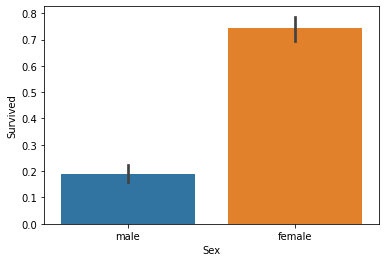

In [115]:
sns.barplot(x='Sex',y='Survived',data = tdf)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

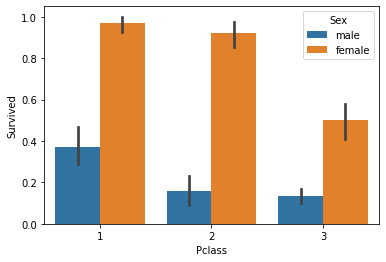

In [116]:
sns.barplot(x='Pclass',y='Survived',hue='Sex',data = tdf)

In [117]:
def age_cat(x):
    cat = ''
    if x<10:
        cat = 'child'
    elif x<20:
        cat = 'teen'
    elif x<30:
        cat = '20s'
    elif x<40:
        cat = '30s'
    elif x<50:
        cat = '40s'
    elif x<60:
        cat = '50s'
    elif x>=60 and x<100:
        cat = 'eldery'
    else: cat = 'unknown'
    return cat
        
tdf['Age_cat'] = tdf.Age.apply(lambda x: age_cat(x))
tdf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20s
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30s
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20s
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30s
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30s


<AxesSubplot:xlabel='Age_cat', ylabel='Survived'>

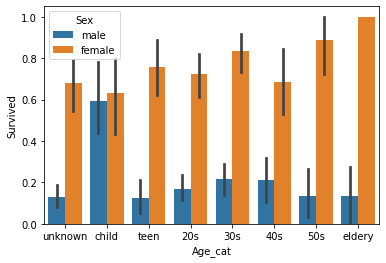

In [118]:
groups = ['unknown','child','teen','20s','30s','40s','50s','eldery']
sns.barplot(x='Age_cat',y='Survived',hue='Sex',data = tdf,order = groups)

In [192]:
# null 처리 함수들
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df
        

In [120]:
tdf.drop('Age_cat',axis = 1,inplace=True)
tdf = transform_features(tdf)

C:\Users\Master\AppData\Local\Temp/ipykernel_39060/506885005.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Cabins'] = df3['Cabin'].str[:1]


In [121]:
tdf

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.000000,1,0,7.2500,5,2
1,1,1,0,38.000000,1,0,71.2833,2,0
2,1,3,0,26.000000,0,0,7.9250,5,2
3,1,1,0,35.000000,1,0,53.1000,2,2
4,0,3,1,35.000000,0,0,8.0500,4,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,4,2
887,1,1,0,19.000000,0,0,30.0000,1,2
888,0,3,0,21.773973,1,2,23.4500,5,2
889,1,1,1,26.000000,0,0,30.0000,2,0


In [122]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    int32  
 8   Embarked  891 non-null    int32  
dtypes: float64(2), int32(3), int64(4)
memory usage: 52.3 KB


In [193]:
from sklearn.model_selection import train_test_split
tdf = pd.read_csv('./dataset/train.csv')
y_data = tdf['Survived']
X_data = tdf.drop('Survived',axis = 1)

X_data = transform_features(X_data)

C:\Users\Master\AppData\Local\Temp/ipykernel_39060/3775927477.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Cabins'] = df3['Cabin'].str[:1]


In [200]:
X_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,0.014151,6,2
1,1,0,38.000000,1,0,0.139136,2,0
2,3,0,26.000000,0,0,0.015469,4,2
3,1,0,35.000000,1,0,0.103644,2,2
4,3,1,35.000000,0,0,0.015713,6,2
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,0.025374,5,2
887,1,0,19.000000,0,0,0.058556,1,2
888,3,0,21.773973,1,2,0.045771,5,2
889,1,1,26.000000,0,0,0.058556,2,0


In [194]:
X_train,X_test, y_train, y_test = train_test_split(X_data,y_data,test_size = 0.2,random_state = 11)

In [195]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [196]:
dt_clf = DecisionTreeClassifier(random_state = 11)
rf_clf = RandomForestClassifier(random_state = 11)
lr_clf = LogisticRegression(random_state = 11)

dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)
print('dt_clf',accuracy_score(y_test,dt_pred))

rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_test)
print('rf_clf',accuracy_score(y_test,rf_pred))

lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
print('lr_clf',accuracy_score(y_test,lr_pred))

dt_clf 0.7988826815642458
rf_clf 0.8547486033519553
lr_clf 0.8603351955307262


C:\Users\Master\anaconda3\envs\cakd5\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [197]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds = 5):
    kfold = KFold(n_splits=folds)
    scores = []
    
    for iter_count,(train_index, test_index) in enumerate(kfold.split(X_data)):
        X_train,X_test = X_data.values[train_index],X_data.values[test_index]
        y_train,y_test = y_data.values[train_index],y_data.values[test_index]
        
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test,predictions)
        scores.append(accuracy)
        print(iter_count,accuracy)
        
    mean_score = np.mean(scores)
    print(mean_score)
    
exec_kfold(rf_clf,folds = 5)

0 0.776536312849162
1 0.797752808988764
2 0.8539325842696629
3 0.7865168539325843
4 0.8426966292134831
0.8114870378507313


In [198]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf,X_data,y_data,cv = 5)
for iter_count ,accuracy in enumerate(scores):
    print(iter_count, accuracy)
    
print(np.mean(scores))

0 0.7653631284916201
1 0.7640449438202247
2 0.8202247191011236
3 0.7640449438202247
4 0.7865168539325843
0.7800389178331556


In [199]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],'min_samples_split':[2,3,5],'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf,param_grid=parameters,scoring='accuracy',cv=5)
grid_dclf.fit(X_train,y_train)

print(grid_dclf.best_params_)
print(grid_dclf.best_score_)
best_dclf = grid_dclf.best_estimator_

dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test,dpredictions)

print(accuracy)

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.807633211858564
0.88268156424581
